### Import Libraries

In [35]:
import pandas as pd
import numpy as np
import re
import nltk
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
nltk.download(['punkt', 'wordnet', 'omw-1.4', 'stopwords'])

[nltk_data] Downloading package punkt to /Users/pranitdas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pranitdas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pranitdas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranitdas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Customize stopwords: Keep negation words for sentiment analysis
negation_words = {'no', 'not', 'nor', 'never', 'none', 'nobody', 'nothing', 
                  'neither', 'nowhere', 'hardly', 'scarcely', 'barely', 'don', "don't"}

stop_words = [word for word in stop_words if word not in negation_words]

### Read Data

In [47]:
df = pd.read_csv('Stock_senti.csv'  , encoding = "ISO-8859-1")

In [80]:
df['Label'].value_counts()

Label
1    2166
0    1935
Name: count, dtype: int64

In [86]:
text_columns = df.columns[2:27]
label_column = df.columns[0:2]

# Melt the DataFrame to reshape from wide to long
long_df = df.melt(id_vars=label_column, value_vars=text_columns, 
                  var_name='feature', value_name='text')

long_df = long_df.dropna()

In [87]:
long_df.head()

,Date,Label,feature,text
0,2000-01-03,0,Top1,A 'hindrance to operations': extracts from the...
1,2000-01-04,0,Top1,Scorecard
2,2000-01-05,0,Top1,Coventry caught on counter by Flo
3,2000-01-06,1,Top1,Pilgrim knows how to progress
4,2000-01-07,1,Top1,Hitches and Horlocks


In [69]:
train , test = train_test_split(long_df , test_size= 0.2 , random_state= 32)

In [88]:
train = long_df[long_df['Date'] < '20150101']
test = long_df[long_df['Date'] > '20141231']

### Preprocessing

In [61]:
def preprocess_text(text):
    """Preprocess individual text"""
    # Expand contractions
    text = contractions.fix(text)
    # Remove special characters/numbers
    text = re.sub(r'[^a-zA-Z!?]', ' ', text)
    # Tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(words)

In [89]:
train['processed_text'] = train['text'].apply(preprocess_text)
test['processed_text'] = test['text'].apply(preprocess_text)

/var/folders/4f/fqrnlkmx3jl8cj0wlvcm9rgw0000gn/T/ipykernel_1282/635080548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['processed_text'] = train['text'].apply(preprocess_text)
/var/folders/4f/fqrnlkmx3jl8cj0wlvcm9rgw0000gn/T/ipykernel_1282/635080548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['processed_text'] = test['text'].apply(preprocess_text)


In [91]:
x_train , x_test = train['processed_text'] , test['processed_text']
y_train , y_test = train['Label'] , test['Label']

In [92]:
'''Count vocabulary'''
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

word_counts = tokenizer.word_counts
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print(f'vocab_size = {len(tokenizer.word_index) + 1}')
vocab_size = 20000

vocab_size = 38316


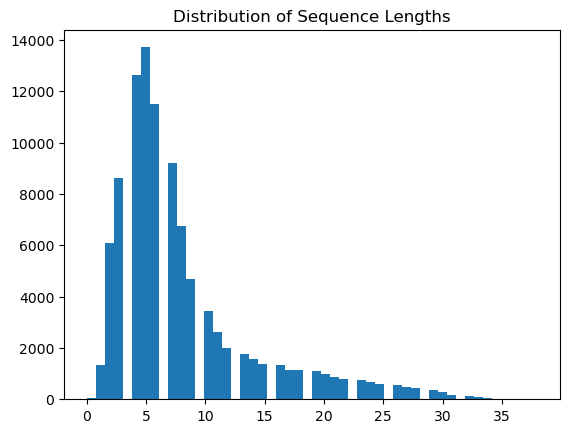

Average length: 8.1
95th percentile: 22.0


In [93]:
sequences = tokenizer.texts_to_sequences(x_train)
sequence_lengths = [len(seq) for seq in sequences]

plt.hist(sequence_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.show()

print(f"Average length: {np.mean(sequence_lengths):.1f}")
print(f"95th percentile: {np.percentile(sequence_lengths, 95)}")

max_length = 22

In [94]:
# Tokenization and padding
tokenizer = Tokenizer(num_words= vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences to uniform length
x_train_pad = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

### Modelling

In [98]:
model = Sequential([
    Embedding(vocab_size, 64, input_length= max_length),
    Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.1)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(16)),
    BatchNormalization(),
    Dense(16, activation='gelu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.build(input_shape=(None, max_length))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 22, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 22, 64)         │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 22, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,129 (5.02 MB)

 Trainable params: 1,315,937 (5.02 MB)

 Non-trainable params: 192 (768.00 B)

In [99]:
history = model.fit(x_train_pad , y_train , epochs= 100 , validation_data= (x_test_pad, y_test) , batch_size= 32)

Epoch 1/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5121 - loss: 0.7080 - val_accuracy: 0.5083 - val_loss: 0.6942
Epoch 2/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.5277 - loss: 0.6916 - val_accuracy: 0.5426 - val_loss: 0.6881
Epoch 3/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.5750 - loss: 0.6765 - val_accuracy: 0.5926 - val_loss: 0.6690
Epoch 4/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.6422 - loss: 0.6328 - val_accuracy: 0.6311 - val_loss: 0.6382
Epoch 5/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.6876 - loss: 0.5792 - val_accuracy: 0.6685 - val_loss: 0.6072
Epoch 6/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.7351 - loss: 0.5160 - val_accuracy: 0.7020 - val_loss: 0.5778
Epoch 7/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.7654 - loss: 0.4581 - val_accuracy: 0.7249 - val_loss: 0.5665
Epoch 8/100
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 

### Validation

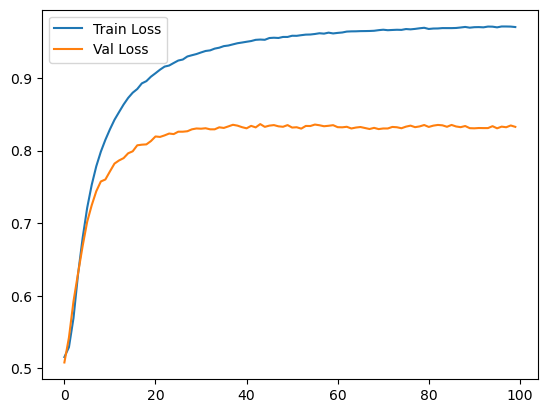

In [100]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Val Loss')
plt.legend()
plt.show()

### Usage

In [101]:
def preprocess_input(text, tokenizer, max_length):
    """Process raw text into model-ready format"""
    # 1. Apply your preprocessing function
    processed_text = preprocess_text(text)  # Use the same function from earlier
    
    # 2. Tokenize using the trained tokenizer
    sequence = tokenizer.texts_to_sequences([processed_text])
    
    # 3. Pad/truncate to match model's expected length
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    return padded

In [102]:
texts = ["Chaos at Delhi airport, over 350 flights delayed due to congestion", "After India Outreach, China Calls On Europe To Resist American 'Bullying'"]
processed_batch = [preprocess_input(t, tokenizer, max_length) for t in texts]
predictions = model.predict(np.vstack(processed_batch))

for text, pred in zip(texts, predictions):
    print(f"{text}: {'Positive' if pred > 0.5 else 'Negative'} ({pred[0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Chaos at Delhi airport, over 350 flights delayed due to congestion: Negative (0.00)
After India Outreach, China Calls On Europe To Resist American 'Bullying': Negative (0.00)
